In [1]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils

from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MultiStateReporter2(MultiStateReporter):
    def read_energies(self, iteration=slice(None)):
        """Retrieve the energy matrix at the given iteration on the analysis file
        Parameters
        ----------
        iteration : int or slice
            The iteration(s) at which to read the data. The slice(None) allows fetching all iterations at once.
        Returns
        -------
        energy_thermodynamic_states : n_replicas x n_states numpy.ndarray
            ``energy_thermodynamic_states[iteration, i, j]`` is the reduced potential computed at
            SamplerState ``sampler_states[iteration, i]`` and ThermodynamicState ``thermodynamic_states[iteration, j]``.
        energy_neighborhoods : n_replicas x n_states numpy.ndarray
            energy_neighborhoods[replica_index, state_index] is 1 if the energy was computed for this state,
            0 otherwise
        energy_unsampled_states : n_replicas x n_unsampled_states numpy.ndarray
            ``energy_unsampled_states[iteration, i, j]`` is the reduced potential computed at SamplerState
            ``sampler_states[iteration, i]`` and ThermodynamicState ``unsampled_thermodynamic_states[iteration, j]``.
        """
        # Determine last consistent iteration
        iteration = self._map_iteration_to_good(iteration)
        # Retrieve energies at all thermodynamic states
        energy_thermodynamic_states = np.array(self._storage_analysis.variables['energies'][iteration, :, :], np.float64)
        # Retrieve neighborhoods, assuming global neighborhoods if reading a pre-neighborhoods file
        try:
            energy_neighborhoods = np.array(self._storage_analysis.variables['neighborhoods'][iteration, :, :], 'i1')
        except KeyError:
            energy_neighborhoods = np.ones(energy_thermodynamic_states.shape, 'i1')
        # Read energies at unsampled states, if present
#         try:
#             energy_unsampled_states = np.array(self._storage_analysis.variables['unsampled_energies'][iteration, :, :], np.float64)
#         except KeyError:
#             # There are no unsampled thermodynamic states.
        unsampled_shape = energy_thermodynamic_states.shape[:-1] + (0,)
        energy_unsampled_states = np.zeros(unsampled_shape)
        return energy_thermodynamic_states, energy_neighborhoods, energy_unsampled_states


In [3]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter2(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
#     iterations_to_analyze = list(range (1, n_iterations, 500)) + [int(n_iterations-1)]
    iterations_to_analyze = range(1, n_iterations, 100)
    print(list(iterations_to_analyze)) # check that this is giving me the last avail iteration
    for step in iterations_to_analyze: 
        analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
        f_ij, df_ij = analyzer.get_free_energy()
        dg.append(f_ij[0,-1])
        ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    print("Neff: ", analyzer.mbar.computeEffectiveSampleNumber())
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg), f_ij, df_ij

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/0)

In [4]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [5]:
main_dir = 32
sub_dir = 3
chunk = 0
titles = ['ALA->THR']

In [6]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501, 3601, 3701, 3801, 3901, 4001, 4101, 4201, 4301, 4401, 4501, 4601, 4701, 4801, 4901]


DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ... 4998 4999 5000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 1
DEBUG:openmmtools.multistate.multistateanalyzer: statistical ineffic

DEBUG:openmmtools.multistate.multistateanalyzer:   9.009   9.009  13.757  15.438  15.576  14.146  11.106   6.405   0.000  -8.142 -18.033 -29.654
DEBUG:openmmtools.multistate.multistateanalyzer:  17.151  17.151  21.900  23.580  23.718  22.288  19.248  14.547   8.142   0.000  -9.891 -21.512
DEBUG:openmmtools.multistate.multistateanalyzer:  27.043  27.043  31.791  33.471  33.609  32.179  29.139  24.439  18.033   9.891   0.000 -11.621
DEBUG:openmmtools.multistate.multistateanalyzer:  38.663  38.663  43.411  45.091  45.230  43.800  40.760  36.059  29.654  21.512  11.621   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.289   0.323   0.339   0.350   0.359   0.368   0.376   0.385   0.395   0.406
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.289   0.323   0.339   0.350   0.359   0.368   0.376   0.385   0.395   0.406
DEBUG:openmmtools.multistate.multistateanalyzer:   0.289   0.289   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ... 4998 4999 5000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to

DEBUG:openmmtools.multistate.multistateanalyzer:   3.297   3.297   7.608   9.216   9.299   7.813   4.724   0.000  -6.400 -14.525 -24.399 -35.989
DEBUG:openmmtools.multistate.multistateanalyzer:   9.697   9.697  14.008  15.616  15.699  14.213  11.124   6.400   0.000  -8.124 -17.999 -29.589
DEBUG:openmmtools.multistate.multistateanalyzer:  17.822  17.822  22.132  23.741  23.824  22.337  19.248  14.525   8.124   0.000  -9.874 -21.464
DEBUG:openmmtools.multistate.multistateanalyzer:  27.696  27.696  32.007  33.615  33.698  32.212  29.123  24.399  17.999   9.874   0.000 -11.590
DEBUG:openmmtools.multistate.multistateanalyzer:  39.286  39.286  43.597  45.205  45.288  43.802  40.713  35.989  29.589  21.464  11.590   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.149   0.168   0.178   0.184   0.189   0.194   0.200   0.205   0.211   0.218
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.1

DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ... 4998 4999 5000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of

DEBUG:openmmtools.multistate.multistateanalyzer:  -1.715  -1.715   2.843   4.458   4.549   3.074   0.000  -4.717 -11.128 -19.274 -29.173 -40.797
DEBUG:openmmtools.multistate.multistateanalyzer:   3.003   3.003   7.560   9.176   9.266   7.792   4.717   0.000  -6.410 -14.556 -24.456 -36.080
DEBUG:openmmtools.multistate.multistateanalyzer:   9.413   9.413  13.971  15.586  15.677  14.202  11.128   6.410   0.000  -8.146 -18.046 -29.670
DEBUG:openmmtools.multistate.multistateanalyzer:  17.559  17.559  22.117  23.732  23.823  22.348  19.274  14.556   8.146   0.000  -9.899 -21.524
DEBUG:openmmtools.multistate.multistateanalyzer:  27.459  27.459  32.016  33.631  33.722  32.248  29.173  24.456  18.046   9.899   0.000 -11.624
DEBUG:openmmtools.multistate.multistateanalyzer:  39.083  39.083  43.640  45.256  45.346  43.872  40.797  36.080  29.670  21.524  11.624   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.1

DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ... 4998 4999 5000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of

DEBUG:openmmtools.multistate.multistateanalyzer:  -4.821  -4.821  -0.243   1.376   1.472   0.000  -3.079  -7.808 -14.229 -22.384 -32.297 -43.943
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.741  -1.741   2.837   4.455   4.552   3.079   0.000  -4.728 -11.150 -19.305 -29.218 -40.863
DEBUG:openmmtools.multistate.multistateanalyzer:   2.987   2.987   7.565   9.183   9.280   7.808   4.728   0.000  -6.421 -14.577 -24.490 -36.135
DEBUG:openmmtools.multistate.multistateanalyzer:   9.408   9.408  13.986  15.605  15.701  14.229  11.150   6.421   0.000  -8.155 -18.068 -29.714
DEBUG:openmmtools.multistate.multistateanalyzer:  17.564  17.564  22.142  23.760  23.857  22.384  19.305  14.577   8.155   0.000  -9.913 -21.558
DEBUG:openmmtools.multistate.multistateanalyzer:  27.477  27.477  32.055  33.673  33.770  32.297  29.218  24.490  18.068   9.913   0.000 -11.645
DEBUG:openmmtools.multistate.multistateanalyzer:  39.122  39.122  43.700  45.319  45.415  43.943  40.863  36.135  29.714  21.558  

DEBUG:openmmtools.multistate.multistateanalyzer:   0.155   0.155   0.092   0.083   0.076   0.069   0.062   0.054   0.044   0.033   0.018   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ... 4998 4999 5000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effecti

DEBUG:openmmtools.multistate.multistateanalyzer:  -6.175  -6.175  -1.712  -0.098   0.000  -1.473  -4.560  -9.299 -15.727 -23.877 -33.770 -45.379
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.702  -4.702  -0.240   1.375   1.473   0.000  -3.087  -7.827 -14.255 -22.405 -32.297 -43.907
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.615  -1.615   2.847   4.462   4.560   3.087   0.000  -4.740 -11.167 -19.318 -29.210 -40.820
DEBUG:openmmtools.multistate.multistateanalyzer:   3.124   3.124   7.587   9.202   9.299   7.827   4.740   0.000  -6.428 -14.578 -24.470 -36.080
DEBUG:openmmtools.multistate.multistateanalyzer:   9.552   9.552  14.015  15.630  15.727  14.255  11.167   6.428   0.000  -8.150 -18.043 -29.652
DEBUG:openmmtools.multistate.multistateanalyzer:  17.702  17.702  22.165  23.780  23.877  22.405  19.318  14.578   8.150   0.000  -9.893 -21.502
DEBUG:openmmtools.multistate.multistateanalyzer:  27.595  27.595  32.057  33.672  33.770  32.297  29.210  24.470  18.043   9.893  

DEBUG:openmmtools.multistate.multistateanalyzer:   0.132   0.132   0.077   0.067   0.059   0.052   0.045   0.036   0.026   0.014   0.000   0.017
DEBUG:openmmtools.multistate.multistateanalyzer:   0.136   0.136   0.083   0.074   0.068   0.061   0.055   0.048   0.040   0.029   0.017   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1 

DEBUG:openmmtools.multistate.multistateanalyzer:  -6.238  -6.238  -1.623   0.000   0.084  -1.405  -4.501  -9.249 -15.693 -23.871 -33.797 -45.439
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.322  -6.322  -1.707  -0.084   0.000  -1.488  -4.585  -9.332 -15.776 -23.955 -33.881 -45.523
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.834  -4.834  -0.219   1.405   1.488   0.000  -3.096  -7.844 -14.288 -22.467 -32.393 -44.034
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.737  -1.737   2.878   4.501   4.585   3.096   0.000  -4.747 -11.192 -19.370 -29.296 -40.938
DEBUG:openmmtools.multistate.multistateanalyzer:   3.010   3.010   7.625   9.249   9.332   7.844   4.747   0.000  -6.444 -14.623 -24.549 -36.190
DEBUG:openmmtools.multistate.multistateanalyzer:   9.454   9.454  14.069  15.693  15.776  14.288  11.192   6.444   0.000  -8.178 -18.104 -29.746
DEBUG:openmmtools.multistate.multistateanalyzer:  17.633  17.633  22.248  23.871  23.955  22.467  19.370  14.623   8.178   0.000  

DEBUG:openmmtools.multistate.multistateanalyzer:   0.121   0.121   0.064   0.055   0.047   0.039   0.032   0.023   0.012   0.000   0.013   0.026
DEBUG:openmmtools.multistate.multistateanalyzer:   0.124   0.124   0.070   0.061   0.054   0.048   0.041   0.034   0.024   0.013   0.000   0.015
DEBUG:openmmtools.multistate.multistateanalyzer:   0.127   0.127   0.075   0.067   0.061   0.056   0.050   0.044   0.036   0.026   0.015   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.

DEBUG:openmmtools.multistate.multistateanalyzer:  -4.662  -4.662   0.000   1.634   1.741   0.272  -2.816  -7.561 -14.000 -22.168 -32.080 -43.709
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.296  -6.296  -1.634   0.000   0.107  -1.362  -4.450  -9.195 -15.634 -23.802 -33.714 -45.343
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.403  -6.403  -1.741  -0.107   0.000  -1.469  -4.557  -9.302 -15.741 -23.909 -33.821 -45.450
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.934  -4.934  -0.272   1.362   1.469   0.000  -3.088  -7.833 -14.272 -22.440 -32.351 -43.981
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.846  -1.846   2.816   4.450   4.557   3.088   0.000  -4.745 -11.184 -19.352 -29.264 -40.893
DEBUG:openmmtools.multistate.multistateanalyzer:   2.899   2.899   7.561   9.195   9.302   7.833   4.745   0.000  -6.439 -14.607 -24.519 -36.148
DEBUG:openmmtools.multistate.multistateanalyzer:   9.338   9.338  14.000  15.634  15.741  14.272  11.184   6.439   0.000  -8.168 -

DEBUG:openmmtools.multistate.multistateanalyzer:   0.105   0.105   0.055   0.045   0.036   0.028   0.020   0.010   0.000   0.011   0.022   0.034
DEBUG:openmmtools.multistate.multistateanalyzer:   0.108   0.108   0.059   0.050   0.043   0.036   0.029   0.021   0.011   0.000   0.012   0.025
DEBUG:openmmtools.multistate.multistateanalyzer:   0.110   0.110   0.064   0.056   0.050   0.044   0.038   0.031   0.022   0.012   0.000   0.014
DEBUG:openmmtools.multistate.multistateanalyzer:   0.114   0.114   0.070   0.063   0.057   0.052   0.047   0.041   0.034   0.025   0.014   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of ty

DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.679   6.302   6.398   4.921   1.825  -2.936  -9.397 -17.590 -27.527 -39.180
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.679  -4.679   0.000   1.623   1.718   0.242  -2.855  -7.615 -14.077 -22.269 -32.206 -43.859
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.302  -6.302  -1.623   0.000   0.095  -1.381  -4.478  -9.238 -15.700 -23.892 -33.829 -45.482
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.398  -6.398  -1.718  -0.095   0.000  -1.476  -4.573  -9.334 -15.795 -23.988 -33.924 -45.577
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.921  -4.921  -0.242   1.381   1.476   0.000  -3.097  -7.857 -14.319 -22.511 -32.448 -44.101
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.825  -1.825   2.855   4.478   4.573   3.097   0.000  -4.761 -11.222 -19.415 -29.351 -41.004
DEBUG:openmmtools.multistate.multistateanalyzer:   2.936   2.936   7.615   9.238   9.334   7.857   4.761   0.000  -6.462 -14.654 -

DEBUG:openmmtools.multistate.multistateanalyzer:   0.098   0.098   0.047   0.036   0.028   0.019   0.010   0.000   0.010   0.019   0.029   0.038
DEBUG:openmmtools.multistate.multistateanalyzer:   0.100   0.100   0.051   0.042   0.035   0.027   0.019   0.010   0.000   0.010   0.021   0.031
DEBUG:openmmtools.multistate.multistateanalyzer:   0.102   0.102   0.056   0.047   0.041   0.034   0.027   0.019   0.010   0.000   0.011   0.023
DEBUG:openmmtools.multistate.multistateanalyzer:   0.105   0.105   0.060   0.053   0.047   0.041   0.035   0.029   0.021   0.011   0.000   0.013
DEBUG:openmmtools.multistate.multistateanalyzer:   0.108   0.108   0.066   0.059   0.053   0.048   0.043   0.038   0.031   0.023   0.013   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic stat

DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.801   6.481   6.611   5.148   2.054  -2.705  -9.162 -17.349 -27.284 -38.943
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.801   6.481   6.611   5.148   2.054  -2.705  -9.162 -17.349 -27.284 -38.943
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.801  -4.801   0.000   1.681   1.810   0.347  -2.746  -7.506 -13.963 -22.150 -32.085 -43.744
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.481  -6.481  -1.681   0.000   0.129  -1.334  -4.427  -9.186 -15.644 -23.830 -33.765 -45.425
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.611  -6.611  -1.810  -0.129   0.000  -1.463  -4.556  -9.315 -15.773 -23.960 -33.894 -45.554
DEBUG:openmmtools.multistate.multistateanalyzer:  -5.148  -5.148  -0.347   1.334   1.463   0.000  -3.094  -7.853 -14.310 -22.497 -32.432 -44.091
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.054  -2.054   2.74

DEBUG:openmmtools.multistate.multistateanalyzer:   0.094   0.094   0.039   0.028   0.019   0.009   0.000   0.009   0.018   0.026   0.034   0.042
DEBUG:openmmtools.multistate.multistateanalyzer:   0.096   0.096   0.044   0.034   0.026   0.018   0.009   0.000   0.009   0.019   0.027   0.036
DEBUG:openmmtools.multistate.multistateanalyzer:   0.098   0.098   0.049   0.040   0.033   0.026   0.018   0.009   0.000   0.010   0.020   0.030
DEBUG:openmmtools.multistate.multistateanalyzer:   0.100   0.100   0.053   0.045   0.039   0.033   0.026   0.019   0.010   0.000   0.011   0.022
DEBUG:openmmtools.multistate.multistateanalyzer:   0.103   0.103   0.058   0.050   0.045   0.039   0.034   0.027   0.020   0.011   0.000   0.012
DEBUG:openmmtools.multistate.multistateanalyzer:   0.105   0.105   0.062   0.056   0.051   0.046   0.042   0.036   0.030   0.022   0.012   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multis

DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.734   6.400   6.527   5.074   1.998  -2.738  -9.175 -17.354 -27.295 -38.965
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.734   6.400   6.527   5.074   1.998  -2.738  -9.175 -17.354 -27.295 -38.965
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.734  -4.734   0.000   1.666   1.793   0.340  -2.736  -7.472 -13.909 -22.088 -32.028 -43.699
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.400  -6.400  -1.666   0.000   0.127  -1.327  -4.403  -9.138 -15.575 -23.754 -33.695 -45.366
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.527  -6.527  -1.793  -0.127   0.000  -1.454  -4.529  -9.265 -15.702 -23.881 -33.822 -45.493
DEBUG:openmmtools.multistate.multistateanalyzer:  -5.074  -5.074  -0.340   1.327   

DEBUG:openmmtools.multistate.multistateanalyzer:   0.084   0.084   0.032   0.020   0.009   0.000   0.009   0.017   0.024   0.031   0.037   0.044
DEBUG:openmmtools.multistate.multistateanalyzer:   0.087   0.087   0.038   0.027   0.018   0.009   0.000   0.009   0.017   0.025   0.032   0.040
DEBUG:openmmtools.multistate.multistateanalyzer:   0.089   0.089   0.042   0.033   0.025   0.017   0.009   0.000   0.009   0.018   0.026   0.035
DEBUG:openmmtools.multistate.multistateanalyzer:   0.091   0.091   0.046   0.038   0.031   0.024   0.017   0.009   0.000   0.009   0.019   0.029
DEBUG:openmmtools.multistate.multistateanalyzer:   0.093   0.093   0.050   0.043   0.037   0.031   0.025   0.018   0.009   0.000   0.010   0.021
DEBUG:openmmtools.multistate.multistateanalyzer:   0.095   0.095   0.055   0.048   0.043   0.037   0.032   0.026   0.019   0.010   0.000   0.012
DEBUG:openmmtools.multistate.multistateanalyzer:   0.098   0.098   0.059   0.053   0.048   0.044   0.040   0.035   0.029   0.021  

DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.715   6.356   6.462   4.996   1.914  -2.827  -9.271 -17.455 -27.399 -39.073
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.715   6.356   6.462   4.996   1.914  -2.827  -9.271 -17.455 -27.399 -39.073
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.715  -4.715   0.000   1.641   1.747   0.281  -2.801  -7.542 -13.986 -22.170 -32.114 -43.788
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.356  -6.356  -1.641   0.000   0.106  -1.360  -4.442  -9.183 -15.626 -23.810 -33.754 -45.429
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.462  -6.462  -1.747  -0.106   0.000 

DEBUG:openmmtools.multistate.multistateanalyzer:   0.081   0.081   0.025   0.011   0.000   0.009   0.017   0.024   0.030   0.036   0.041   0.046
DEBUG:openmmtools.multistate.multistateanalyzer:   0.084   0.084   0.031   0.019   0.009   0.000   0.008   0.016   0.024   0.030   0.036   0.042
DEBUG:openmmtools.multistate.multistateanalyzer:   0.086   0.086   0.036   0.026   0.017   0.008   0.000   0.008   0.016   0.024   0.031   0.038
DEBUG:openmmtools.multistate.multistateanalyzer:   0.088   0.088   0.041   0.031   0.024   0.016   0.008   0.000   0.009   0.017   0.025   0.033
DEBUG:openmmtools.multistate.multistateanalyzer:   0.090   0.090   0.045   0.037   0.030   0.024   0.016   0.009   0.000   0.009   0.018   0.027
DEBUG:openmmtools.multistate.multistateanalyzer:   0.092   0.092   0.049   0.041   0.036   0.030   0.024   0.017   0.009   0.000   0.010   0.020
DEBUG:openmmtools.multistate.multistateanalyzer:   0.094   0.094   0.053   0.046   0.041   0.036   0.031   0.025   0.018   0.010  

DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.807   6.496   6.632   5.182   2.107  -2.633  -9.077 -17.257 -27.185 -38.826
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.807   6.496   6.632   5.182   2.107  -2.633  -9.077 -17.257 -27.185 -38.826
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.807  -4.807   0.000   1.690   1.826   0.376  -2.699  -7.439 -13.884 -22.064 -31.992 -43.633
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.496  -6.496  -1.690   0.000   0.136  -1.314  -4.389  -9.129 -15.573 -23.754 -33.681 -45.323
DEBUG

DEBUG:openmmtools.multistate.multistateanalyzer:   0.076   0.076   0.023   0.010   0.000   0.009   0.016   0.023   0.029   0.034   0.039   0.045
DEBUG:openmmtools.multistate.multistateanalyzer:   0.078   0.078   0.030   0.018   0.009   0.000   0.008   0.016   0.022   0.029   0.035   0.041
DEBUG:openmmtools.multistate.multistateanalyzer:   0.080   0.080   0.035   0.025   0.016   0.008   0.000   0.008   0.016   0.023   0.030   0.037
DEBUG:openmmtools.multistate.multistateanalyzer:   0.082   0.082   0.039   0.030   0.023   0.016   0.008   0.000   0.008   0.016   0.024   0.032
DEBUG:openmmtools.multistate.multistateanalyzer:   0.084   0.084   0.043   0.035   0.029   0.022   0.016   0.008   0.000   0.009   0.018   0.026
DEBUG:openmmtools.multistate.multistateanalyzer:   0.086   0.086   0.047   0.040   0.034   0.029   0.023   0.016   0.009   0.000   0.009   0.019
DEBUG:openmmtools.multistate.multistateanalyzer:   0.088   0.088   0.051   0.044   0.039   0.035   0.030   0.024   0.018   0.009  

DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.610   6.267   6.393   4.936   1.852  -2.896  -9.344 -17.532 -27.477 -39.147
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.610   6.267   6.393   4.936   1.852  -2.896  -9.344 -17.532 -27.477 -39.147
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.610  -4.610   0.000   1.657   1.783   0.326  -2.758  -7.506 -13.955 -22.142 -32.087 -43.758
DEBUG:openmmtools.multistate.multistateanalyzer:  -6.267  -6.267  -1.657   0.000   0.126  -1.331  -4.415  -9.163 -15.612 -23.799 -33.744 -45.415
DEBUG

DEBUG:openmmtools.multistate.multistateanalyzer:   0.068   0.068   0.014   0.000   0.010   0.017   0.023   0.029   0.033   0.038   0.042   0.047
DEBUG:openmmtools.multistate.multistateanalyzer:   0.072   0.072   0.022   0.010   0.000   0.008   0.015   0.022   0.027   0.033   0.038   0.043
DEBUG:openmmtools.multistate.multistateanalyzer:   0.074   0.074   0.028   0.017   0.008   0.000   0.008   0.015   0.021   0.028   0.033   0.039
DEBUG:openmmtools.multistate.multistateanalyzer:   0.076   0.076   0.033   0.023   0.015   0.008   0.000   0.008   0.015   0.022   0.029   0.035
DEBUG:openmmtools.multistate.multistateanalyzer:   0.078   0.078   0.037   0.029   0.022   0.015   0.008   0.000   0.008   0.016   0.023   0.031
DEBUG:openmmtools.multistate.multistateanalyzer:   0.080   0.080   0.041   0.033   0.027   0.021   0.015   0.008   0.000   0.008   0.017   0.025
DEBUG:openmmtools.multistate.multistateanalyzer:   0.082   0.082   0.045   0.038   0.033   0.028   0.022   0.016   0.008   0.000  

DEBUG:openmmtools.multistate.multistateanalyzer: statistical inefficiency of production region   : 3.7267348766326904
DEBUG:openmmtools.multistate.multistateanalyzer: effective number of uncorrelated samples        : 1073.8623046875
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.601   6.237   6.343   4.870   1.776  -2.977  -9.426 -17.607 -27.541 -39.201
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.601   6.237   6.343   4.870   1.776  -2.977  -9.426 -17.607 -27.541 -39.201
DEBUG:openmmtools.multistate.multistateanalyzer:  -4.601  -4.6

DEBUG:openmmtools.multistate.multistateanalyzer:   0.061   0.061   0.000   0.013   0.022   0.027   0.032   0.036   0.039   0.043   0.047   0.051
DEBUG:openmmtools.multistate.multistateanalyzer:   0.067   0.067   0.013   0.000   0.009   0.017   0.023   0.028   0.032   0.037   0.041   0.045
DEBUG:openmmtools.multistate.multistateanalyzer:   0.071   0.071   0.022   0.009   0.000   0.008   0.015   0.021   0.026   0.032   0.036   0.041
DEBUG:openmmtools.multistate.multistateanalyzer:   0.073   0.073   0.027   0.017   0.008   0.000   0.007   0.014   0.021   0.027   0.032   0.038
DEBUG:openmmtools.multistate.multistateanalyzer:   0.075   0.075   0.032   0.023   0.015   0.007   0.000   0.007   0.014   0.021   0.028   0.034
DEBUG:openmmtools.multistate.multistateanalyzer:   0.076   0.076   0.036   0.028   0.021   0.014   0.007   0.000   0.008   0.015   0.022   0.029
DEBUG:openmmtools.multistate.multistateanalyzer:   0.078   0.078   0.039   0.032   0.026   0.021   0.014   0.008   0.000   0.008  

DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 1
DEBUG:openmmtools.multistate.multistateanalyzer: statistical inefficiency of production region   : 3.796422243118286
DEBUG:openmmtools.multistate.multistateanalyzer: effective number of uncorrelated samples        : 1133.172119140625
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.635   6.310   6.442   4.989   1.911  -2.829  -9.271 -17.453 -27.394 -39.065
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   4.635   6.310   6.442   4.989   1.911 

DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.060   0.067   0.070   0.072   0.074   0.075   0.077   0.079   0.081   0.083
DEBUG:openmmtools.multistate.multistateanalyzer:   0.060   0.060   0.000   0.014   0.021   0.027   0.031   0.035   0.038   0.042   0.045   0.049
DEBUG:openmmtools.multistate.multistateanalyzer:   0.067   0.067   0.014   0.000   0.009   0.016   0.022   0.027   0.031   0.035   0.039   0.044
DEBUG:openmmtools.multistate.multistateanalyzer:   0.070   0.070   0.021   0.009   0.000   0.008   0.014   0.020   0.026   0.030   0.035   0.040
DEBUG:openmmtools.multistate.multistateanalyzer:   0.072   0.072   0.027   0.016   0.008   0.000   0.007   0.014   0.020   0.026   0.031   0.036
DEBUG:openmmtools.multistate.multistateanalyzer:   0.074   0.074   0.031   0.022   0.014   0.007   0.000   0.007   0.014   0.021   0.027   0.033
DEBUG:openmmtools.multistate.multistateanalyzer:   0.075   0.075   0.035   0.027   0.020   0.014   0.007   0.000   0.007   0.015  

DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 1
DEBUG:openmmtools.multistate.multistateanalyzer: statistical inefficiency of production region   : 3.8144428730010986
DEBUG:openmmtools.multistate.multistateanalyzer: effective number of uncorrelated samples        : 1206.4671630859375
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.057   0.064   0.067   0.069   0.070   0.072   0.074   0.075   0.077   0.079
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.057   0.064   0.067   0.069   0.070   0.072   0.074   0.075   0.077   0.079
DEBUG:openmmtools.multistate.multistateanalyzer:   0.057   0.057   0.000   0.013   0.021   0.026   0.030   0.034   0.037   0.041   0.044   0.047
DEBUG:openmmtools.multistate.multistateanalyzer:   0.064   0.064   0.013   0.000   0.009   0.016   0.021   0.026   0.030   0.034   0.038   0.042
DEBUG:openmmtools.multistate.multistateanalyzer:   0.067   0.067   0.021   0.009   0.000   0.007   0.014   0.020   0.025   0.030   0.034   0.039
DEBUG:openmmtools.multistate.multistateanalyzer:   0.069   0.069   0.026   0.016   0.007   0.000   0.007   0.014   0.020   0.025   0.030   0.035
DEBUG:openmmtools.multistate.multistateanalyzer:   0.070   0.070   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 1
DEBUG:openmmtools.multistate.multistateanalyzer: statistical inefficiency of production region   : 3.770015239715576
DEBUG:openmmtools.multistate.multistateanalyzer: effective number of uncorrelated samples        : 1300.260009765625
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openm

DEBUG:openmmtools.multistate.multistateanalyzer:  39.053  39.053  43.758  45.421  45.536  44.068  40.982  36.240  29.799  21.617  11.674   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.054   0.061   0.063   0.065   0.067   0.069   0.070   0.072   0.074   0.076
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.054   0.061   0.063   0.065   0.067   0.069   0.070   0.072   0.074   0.076
DEBUG:openmmtools.multistate.multistateanalyzer:   0.054   0.054   0.000   0.012   0.020   0.025   0.029   0.032   0.036   0.039   0.042   0.046
DEBUG:openmmtools.multistate.multistateanalyzer:   0.061   0.061   0.012   0.000   0.009   0.015   0.020   0.025   0.029   0.033   0.037   0.041
DEBUG:openmmtools.multistate.multistateanalyzer:   0.063   0.063   0.020   0.009   0.000   0.007   0.013   0.019   0.024   0.028   0.033   0.037
DEBUG:openmmtools.multistate.multistateanalyzer:   0.065   0.065   0.0

Neff:  [2939.41136091 2939.41136091 3945.21469001 5729.84468026 6980.33795478
 7709.49597488 8052.07663786 8123.66877422 7891.63530594 7091.71322191
 5549.7709131  3534.43842555]


In [7]:
apo_dg

array([-38.12848388, -38.66309063, -38.94669624, -38.8946129 ,
       -39.28618639, -39.26468308, -39.38835957, -39.08287784,
       -39.18441832, -39.14291889, -39.12227244, -39.13084332,
       -39.05589916, -39.20434755, -39.0941948 , -39.04045506,
       -39.20053891, -38.99790165, -38.91555136, -39.04663307,
       -39.27321015, -39.06506384, -39.17968253, -39.17069457,
       -38.9937386 , -38.94321439, -38.95875644, -39.0388974 ,
       -38.96543816, -39.03979338, -39.26707353, -39.07335723,
       -38.81083579, -39.06776824, -38.82632   , -38.96534875,
       -39.03490024, -39.14748068, -39.02688908, -39.0842743 ,
       -39.20053972, -39.04572034, -39.03795415, -39.06520762,
       -38.90841608, -38.85193741, -38.98110444, -38.92994466,
       -39.00382515, -38.94174132, -39.05260936])

In [8]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


0 apo: -39.052609360638186 (0.0758745716050181) kT



In [9]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so ti

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal 200 normal>) = 0.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIX' (STIX-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) 

<Figure size 1080x1728 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/1)

In [10]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [11]:
main_dir = 32
sub_dir = 3
chunk = 1
titles = ['ALA->THR']

In [12]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501, 3601, 3701, 3801, 3901, 4001, 4101, 4201, 4301, 4401, 4501, 4601, 4701, 4801, 4901]


Neff:  [3012.21997752 3012.21997752 3317.56749731 4822.0232305  6139.09909213
 6976.59795982 5375.16741654 5350.99398788 6753.15601661 5886.07615549
 4538.30560971 2572.16580421]


In [13]:
apo_dg

array([-44.50781543, -42.75537148, -42.60072502, -42.87412381,
       -43.51126353, -43.74453509, -43.7471678 , -43.54013361,
       -43.82013602, -43.83110593, -43.8889616 , -44.06393065,
       -44.09586084, -43.99327078, -44.14314407, -44.11956176,
       -44.16287249, -44.03016794, -44.06645611, -44.00479677,
       -44.04648652, -44.15984757, -44.11460085, -43.90756489,
       -43.84233789, -43.87419763, -44.10401392, -44.13256686,
       -44.14850267, -44.0731198 , -43.88964507, -44.11298447,
       -44.0043176 , -44.07213227, -44.02912895, -44.12625772,
       -44.11252187, -44.01446988, -43.98860928, -43.94417307,
       -43.807551  , -43.95458699, -43.93010402, -43.85035944,
       -44.00436725, -43.94511341, -43.96523966, -44.01828574,
       -43.98165611, -44.04777797, -43.88457427])

In [14]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


1 apo: -43.884574270055694 (0.08333451953614174) kT



In [15]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/2)

In [16]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [17]:
main_dir = 32
sub_dir = 3
chunk = 2
titles = ['ALA->THR']

In [18]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501, 3601, 3701, 3801, 3901, 4001, 4101, 4201, 4301, 4401, 4501, 4601, 4701, 4801, 4901]


Neff:  [2922.42420103 2922.42420103 2635.77113811 3546.05206595 4120.89528506
 4707.87363734 3646.15989696 3640.15486239 4569.15997751 3863.3611443
 3296.56583411 1989.92622325]


In [19]:
apo_dg

array([-49.62685113, -48.73358411, -47.68825754, -48.1527877 ,
       -47.47198105, -47.80107502, -47.45123448, -47.49486054,
       -47.56410696, -47.36444054, -47.67965797, -47.63553892,
       -47.67429412, -47.4960775 , -47.84430947, -47.75340221,
       -47.66527161, -47.78126451, -47.73732379, -47.60788238,
       -47.8079914 , -47.78834551, -47.73277964, -47.96901171,
       -47.7848853 , -47.68144366, -47.97139837, -47.66767704,
       -47.90487696, -47.86488304, -47.74340131, -47.70374255,
       -47.76634104, -47.73898673, -47.70781853, -47.90491346,
       -47.83260233, -47.9436319 , -47.93242765, -47.87701122,
       -47.78881389, -47.76660527, -47.89686594, -47.98055661,
       -47.74950654, -47.8886633 , -47.81040645, -47.8934723 ,
       -47.93405007, -47.81012751, -47.71332708])

In [20]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


2 apo: -47.71332707689704 (0.09728648634571012) kT



In [21]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

# Plot

In [22]:
d_results = {}

for chunk in [0, 1, 2]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[chunk] = results

In [33]:
d_results[0][0]

array([-38.12848388, -38.66309063, -38.94669624, -38.8946129 ,
       -39.28618639, -39.26468308, -39.38835957, -39.08287784,
       -39.18441832, -39.14291889, -39.12227244, -39.13084332,
       -39.05589916, -39.20434755, -39.0941948 , -39.04045506,
       -39.20053891, -38.99790165, -38.91555136, -39.04663307,
       -39.27321015, -39.06506384, -39.17968253, -39.17069457,
       -38.9937386 , -38.94321439, -38.95875644, -39.0388974 ,
       -38.96543816, -39.03979338, -39.26707353, -39.07335723,
       -38.81083579, -39.06776824, -38.82632   , -38.96534875,
       -39.03490024, -39.14748068, -39.02688908, -39.0842743 ,
       -39.20053972, -39.04572034, -39.03795415, -39.06520762,
       -38.90841608, -38.85193741, -38.98110444, -38.92994466,
       -39.00382515, -38.94174132, -39.05260936])

In [54]:
def plot_series(d_results, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
    labels = ['No REST', 'T_max = 600 K', 'T_max = 1200 K']
    for r in range(len(d_results.keys())):
#         dg_discarded = dg[r][7:] # 7 * 200 = 1400 ps discarded
#         ddg_discarded = ddg[r][7:]
        dg_discarded = d_results[r][0]
        ddg_discarded = d_results[r][1]

        # dg
        ax = axes[0]
#         x = [(j)*.2 + 1.4 for j in range(len(dg_discarded))] # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        x = np.array(range(len(dg_discarded)))/10 # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        y = dg_discarded
        ax.plot(x, y, color=sns.color_palette()[r], label=f'{labels[r]}')
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
#         x = [(j)*.2 + 1.4 for j in range(len(ddg_discarded))]
        x = np.array(range(len(ddg_discarded)))/10
        y = ddg_discarded
        ax.plot(x, y, color=sns.color_palette()[r])

#         # deviation from mean
#         ax = axes[2]
#         x = [(i)/20 + 1.5 for i in range(len(dg_discarded))]
#         y = np.array(dg_discarded) - mean # Need to the average solvent dg across replicates
#         ax.plot(x, y, color=sns.color_palette()[0])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
#     axes[2].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    axes[0].legend()
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/{chunk}_{phase}_series.png", dpi=500)
#     plt.clf()

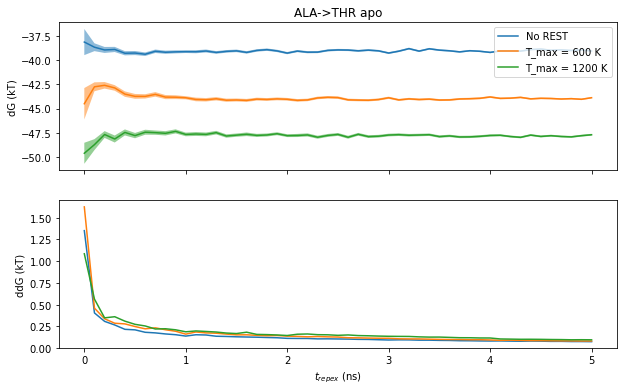

In [55]:
plot_series(d_results, 'apo', 'ALA->THR')